# Squad Analysis Demo

This notebook demonstrates squad analysis capabilities:
1. Parsing squad lists from Wikipedia/text
2. Analyzing squad strength and depth
3. Predicting likely lineups
4. Quantifying injury impact
5. Comparing squads across tournament

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rugby_ranking.model.squad_analysis import (
    SquadParser, 
    SquadAnalyzer,
    LineupPredictor,
    InjuryImpactAnalyzer,
)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Parse Squad from Wikipedia

Example: Scotland Six Nations 2025 squad (paste from Wikipedia)

In [2]:
# Example Wikipedia format squad text
scotland_squad_text = """
Ewan Ashman 	Hooker 	3 April 2000 (aged 25) 	32 	Scotland Edinburgh
Dave Cherry 	Hooker 	3 January 1991 (aged 35) 	16 	France Vannes
George Turner 	Hooker 	10 August 1992 (aged 33) 	50 	England Harlequins
Zander Fagerson 	Prop 	19 January 1996 (aged 30) 	76 	Scotland Glasgow Warriors
Nathan McBeth 	Prop 	8 June 1998 (aged 27) 	5 	Scotland Glasgow Warriors
Elliot Millar-Mills 	Prop 	8 July 1992 (aged 33) 	11 	England Northampton Saints
D'Arcy Rae 	Prop 	21 December 1994 (aged 31) 	5 	Scotland Edinburgh
Pierre Schoeman 	Prop 	7 May 1994 (aged 31) 	44 	Scotland Edinburgh
Rory Sutherland 	Prop 	24 August 1992 (aged 33) 	46 	Scotland Glasgow Warriors
Gregor Brown 	Lock 	1 July 2001 (aged 24) 	12 	Scotland Glasgow Warriors
Alex Craig 	Lock 	26 April 1997 (aged 28) 	6 	Scotland Glasgow Warriors
Scott Cummings 	Lock 	3 December 1996 (aged 29) 	45 	Scotland Glasgow Warriors
Grant Gilchrist 	Lock 	9 August 1990 (aged 35) 	83 	Scotland Edinburgh
Jonny Gray 	Lock 	14 March 1994 (aged 31) 	81 	France Bordeaux
Max Williamson 	Lock 	5 August 2002 (aged 23) 	9 	Scotland Glasgow Warriors
Josh Bayliss 	Back row 	18 September 1997 (aged 28) 	14 	England Bath
Magnus Bradbury 	Back row 	23 August 1995 (aged 30) 	21 	Scotland Edinburgh
Rory Darge 	Back row 	23 February 2000 (aged 25) 	34 	Scotland Glasgow Warriors
Jack Dempsey 	Back row 	12 April 1994 (aged 31) 	29 	Scotland Glasgow Warriors
Freddy Douglas 	Back row 	20 May 2005 (aged 20) 	1 	Scotland Edinburgh
Matt Fagerson 	Back row 	16 July 1998 (aged 27) 	59 	Scotland Glasgow Warriors
Liam McConnell 	Back row 	24 June 2004 (aged 21) 	1 	Scotland Edinburgh
Jamie Ritchie 	Back row 	16 August 1996 (aged 29) 	61 	France Perpignan
Jamie Dobie 	Scrum-half 	7 June 2001 (aged 24) 	17 	Scotland Glasgow Warriors
George Horne 	Scrum-half 	12 May 1995 (aged 30) 	40 	Scotland Glasgow Warriors
Ben White 	Scrum-half 	27 May 1998 (aged 27) 	31 	France Toulon
Fergus Burke 	Fly-half 	3 September 1999 (aged 26) 	3 	England Saracens
Adam Hastings 	Fly-half 	5 October 1996 (aged 29) 	35 	Scotland Glasgow Warriors
Finn Russell 	Fly-half 	23 September 1992 (aged 33) 	89 	England Bath
Rory Hutchinson 	Centre 	29 January 1996 (aged 30) 	11 	England Northampton Saints
Huw Jones 	Centre 	17 December 1993 (aged 32) 	58 	Scotland Glasgow Warriors
Tom Jordan 	Centre 	18 September 1998 (aged 27) 	12 	England Bristol Bears
Stafford McDowall 	Centre 	24 February 1998 (aged 27) 	16 	Scotland Glasgow Warriors
Sione Tuipulotu (c) 	Centre 	12 February 1997 (aged 28) 	33 	Scotland Glasgow Warriors
Darcy Graham 	Wing 	21 June 1997 (aged 28) 	50 	Scotland Edinburgh
Kyle Rowe 	Wing 	8 February 1998 (aged 27) 	17 	Scotland Glasgow Warriors
Kyle Steyn 	Wing 	29 January 1994 (aged 32) 	28 	Scotland Glasgow Warriors
Duhan van der Merwe 	Wing 	4 June 1995 (aged 30) 	52 	Scotland Edinburgh
Blair Kinghorn 	Fullback 	18 January 1997 (aged 29) 	62 	France Toulouse
Ollie Smith 	Fullback 	7 August 2000 (aged 25) 	12 	Scotland Glasgow Warriors

"""


In [17]:

# Parse the squad
parser = SquadParser()
scotland_squad = parser.parse_text(
    scotland_squad_text,
    team="Scotland",
    season="2025-2026"
)

print(f"Parsed {len(scotland_squad)} players")
print(f"\nSample:")
scotland_squad[['player', 'primary_position', 'club', 'section']].head(10)

Parsed 40 players

Sample:


,player,primary_position,club,section
0,Ewan Ashman,Hooker,Edinburgh,forwards
1,Dave Cherry,Hooker,Vannes,forwards
2,George Turner,Hooker,Harlequins,forwards
3,Zander Fagerson,Prop,Glasgow Warriors,forwards
4,Nathan McBeth,Prop,Glasgow Warriors,forwards
5,Elliot Millar-Mills,Prop,Northampton Saints,forwards
6,D'Arcy Rae,Prop,Edinburgh,forwards
7,Pierre Schoeman,Prop,Edinburgh,forwards
8,Rory Sutherland,Prop,Glasgow Warriors,forwards
9,Gregor Brown,Lock,Glasgow Warriors,forwards


## 2. Squad Overview

Players by position:
primary_position
back row      8
Lock          6
Prop          6
Centre        5
Wing          4
Hooker        3
Scrum-half    3
Fly-half      3
Fullback      2
Name: count, dtype: int64


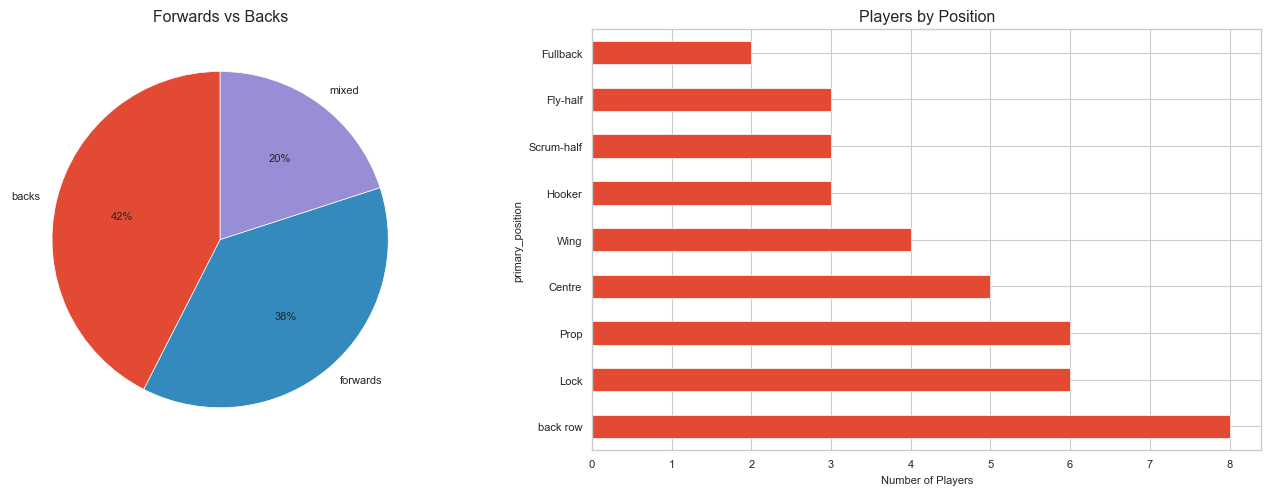

In [4]:
# Count players by position
position_counts = scotland_squad['primary_position'].value_counts()

print("Players by position:")
print(position_counts)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Forwards vs Backs
section_counts = scotland_squad['section'].value_counts()
ax1.pie(section_counts, labels=section_counts.index, autopct='%1.0f%%', startangle=90)
ax1.set_title('Forwards vs Backs')

# By position
position_counts.plot(kind='barh', ax=ax2)
ax2.set_title('Players by Position')
ax2.set_xlabel('Number of Players')

plt.tight_layout()
plt.show()

## 3. Save Squad Data

In [5]:
# Save to CSV
import os

os.makedirs('../squads', exist_ok=True)
scotland_squad.to_csv('../squads/scotland_2025-2026.csv', index=False)
print("Squad saved to: ../squads/scotland_2025-2026.csv")

Squad saved to: ../squads/scotland_2025-2026.csv


## 4. Squad Analysis (Implemented)

This section now uses the implemented `SquadAnalyzer` to:
- Extract player ratings with uncertainty (handles missing players)
- Build depth charts by position (primary + secondary)
- Compute position strength and depth drop-off
- Calculate overall squad strength and depth score
- Generate a likely starting XV and bench (simple heuristic)

CLI example: `rugby-ranking squad analyze --team "Scotland" --season "2024-2025"`

In [9]:
from rugby_ranking.model.data_utils import (
    quick_load,
    prepare_season_data,
    quick_standings,
    get_competition_summary,
)
from rugby_ranking.cli import load_checkpoint

In [11]:
# Load model + dataset (see 02_model_fitting.ipynb)
# from rugby_ranking.model.inference import ModelFitter
# fitter = ModelFitter.load_checkpoint('../checkpoints/latest.pkl')
# model = fitter.model
# trace = fitter.trace
# dataset = fitter.dataset
model, trace = load_checkpoint("joint_model_v3", verbose=True)
# Before: Multiple lines of Path, MatchDataset, load_json_files, etc.
# Now: One line!
dataset = quick_load("../../Rugby-Data")

# See what's available
summary = get_competition_summary(dataset)


Loading checkpoint: joint_model_v3
Loaded checkpoint from /home/daniel/.cache/rugby_ranking/joint_model_v3
✓ Loaded successfully
  Players: 13,786
  Team-seasons: 1126
Loaded 10029 matches from ../../Rugby-Data/json
Found 10448 unique players
Found 112 unique teams


In [12]:


# Analyze squad
analyzer = SquadAnalyzer(model, trace, dataset)
scotland_analysis = analyzer.analyze_squad(
    scotland_squad,
    team="Scotland",
    season="2025-2026"
 )

# Key outputs
print(f"Overall strength: {scotland_analysis.overall_strength:.2f}")
print(f"Depth score: {scotland_analysis.depth_score:.2f}")

scotland_analysis.position_strength.head(10)

scotland_analysis.likely_xv  # Dict[position, player]
scotland_analysis.likely_bench  # List of bench players


Analyzing squad for Scotland (2025-2026)...
Extracting player ratings from model...
  Matched 40/40 players to model
Creating depth chart...
Calculating position strength...
✓ Analysis complete
  Overall Strength: 0.56/1.00
  Squad Depth Score: 0.30/1.00

Overall strength: 0.56
Depth score: 0.30


['George Turner',
 'Dave Cherry',
 'Zander Fagerson',
 'Nathan McBeth',
 'Rory Sutherland',
 "D'Arcy Rae",
 'Elliot Millar-Mills',
 'Gregor Brown']

In [14]:
scotland_analysis.likely_xv

{'Hooker': 'Ewan Ashman',
 'Prop': 'Pierre Schoeman',
 'Lock': 'Scott Cummings',
 'back row': 'Magnus Bradbury',
 'Scrum-half': 'George Horne',
 'Fly-half': 'Fergus Burke',
 'Centre': 'Huw Jones',
 'Wing': 'Darcy Graham',
 'Fullback': 'Blair Kinghorn'}

## 5. Parse Multiple Squads

Example workflow for all Six Nations teams

In [16]:
# For demonstration, parse simple format for other teams
france_squad = """
Maxime Lamothe 	Hooker 	3 October 1998 (aged 27) 	2 	France Bordeaux Bègles
Julien Marchand 	Hooker 	10 May 1995 (aged 30) 	48 	France Toulouse
Peato Mauvaka 	Hooker 	10 January 1997 (aged 29) 	42 	France Toulouse
Dorian Aldegheri 	Prop 	4 August 1993 (aged 32) 	23 	France Toulouse
Uini Atonio 	Prop 	26 March 1990 (aged 35) 	68 	France La Rochelle
Cyril Baille 	Prop 	15 September 1993 (aged 32) 	57 	France Toulouse
Jean-Baptiste Gros 	Prop 	29 May 1999 (aged 26) 	40 	France Toulon
Régis Montagne 	Prop 	30 September 2000 (aged 25) 	5 	France Clermont
Rodrigue Neti 	Prop 	28 April 1995 (aged 30) 	4 	France Toulouse
Dany Priso 	Prop 	2 January 1994 (aged 32) 	18 	France Toulon
Tevita Tatafu 	Prop 	13 October 2002 (aged 23) 	2 	France Bayonne
Hugo Auradou 	Lock 	20 July 2003 (aged 22) 	10 	France Pau
Thibaud Flament 	Lock 	29 April 1997 (aged 28) 	34 	France Toulouse
Mickaël Guillard 	Lock 	10 December 2000 (aged 25) 	13 	France Lyon
Emmanuel Meafou 	Lock 	12 July 1998 (aged 27) 	11 	France Toulouse
Tom Staniforth 	Lock 	13 August 1994 (aged 31) 	0 	France Castres
Cameron Woki 	Lock 	7 November 1998 (aged 27) 	31 	France Bordeaux Bègles
Paul Boudehent 	Back row 	21 November 1999 (aged 26) 	21 	France La Rochelle
François Cros 	Back row 	25 March 1994 (aged 31) 	39 	France Toulouse
Alexandre Fischer 	Back row 	19 January 1998 (aged 28) 	3 	France Bayonne
Oscar Jégou 	Back row 	31 May 2003 (aged 22) 	9 	France La Rochelle
Anthony Jelonch 	Back row 	28 July 1996 (aged 29) 	35 	France Toulouse
Temo Matiu 	Back row 	20 July 2001 (aged 24) 	0 	France Bordeaux Bègles
Lenni Nouchi 	Back row 	24 November 2003 (aged 22) 	2 	France Montpellier
Charles Ollivon 	Back row 	11 May 1993 (aged 32) 	48 	France Toulon
Thibault Daubagna 	Scrum-half 	20 May 1994 (aged 31) 	2 	France Pau
Antoine Dupont (c) 	Scrum-half 	15 November 1996 (aged 29) 	59 	France Toulouse
Baptiste Serin 	Scrum-half 	20 July 1994 (aged 31) 	46 	France Toulon
Matthieu Jalibert 	Fly-half 	6 November 1998 (aged 27) 	35 	France Bordeaux Bègles
Ugo Seunes 	Fly-half 	15 November 2000 (aged 25) 	0 	France Racing 92
Fabien Brau-Boirie 	Centre 	19 December 2005 (aged 20) 	0 	France Pau
Nicolas Depoortère 	Centre 	13 January 2003 (aged 23) 	7 	France Bordeaux Bègles
Kalvin Gourgues 	Centre 	27 March 2005 (aged 20) 	1 	France Toulouse
Yoram Moefana 	Centre 	18 July 2000 (aged 25) 	36 	France Bordeaux Bègles
Noah Nene 	Centre 	14 October 2004 (aged 21) 	0 	France Stade Français
Théo Attissogbé 	Wing 	19 November 2004 (aged 21) 	8 	France Pau
Louis Bielle-Biarrey 	Wing 	16 June 2003 (aged 22) 	22 	France Bordeaux Bègles
Gaël Dréan 	Wing 	22 October 2000 (aged 25) 	0 	France Toulon
Aaron Grandidier-Nkanang 	Wing 	18 May 2000 (aged 25) 	0 	France Pau
Grégoire Arfeuil 	Fullback 	5 December 2004 (aged 21) 	0 	France Pau
Romain Buros 	Fullback 	31 July 1997 (aged 28) 	1 	France Bordeaux Bègles
Thomas Ramos 	Fullback 	23 July 1995 (aged 30) 	47 	France Toulouse
"""

france_squad = parser.parse_text(
    france_squad,
    team="France",
    season="2024-2025",
    format='simple'
)

print(f"\nFrance squad: {len(france_squad)} players")
france_squad[['player', 'primary_position', 'club']].head()


France squad: 0 players


KeyError: "['player', 'club'] not in index"

## 6. Interactive Squad Input

In a terminal/command-line environment, you can use the interactive function:

In [ ]:
# This would be run from command line:
# from rugby_ranking.model.squad_analysis import input_squad_interactive
# squad = input_squad_interactive("Ireland", "2024-2025")

print("""
In a terminal, run:

python -c "from rugby_ranking.model.squad_analysis import input_squad_interactive; 
squad = input_squad_interactive('Ireland', '2024-2025')"

Then paste your squad list and press Ctrl+D (Unix) or Ctrl+Z (Windows)
""")

# Parse the squad using auto-detection
parser = SquadParser()
scotland_squad = parser.parse_text(
    scotland_squad_text,
    team="Scotland",
    season="2024-2025"
    # format will auto-detect as 'wikipedia_sixnations'
)

print(f"Parsed {len(scotland_squad)} players")
print(f"\nSample:")
print(scotland_squad[['player', 'primary_position', 'club']].head(10))


In [ ]:
# TODO: Once SquadComparator is implemented

# from rugby_ranking.model.squad_analysis import SquadComparator

# squads = {
#     'Scotland': scotland_analysis,
#     'England': england_analysis,
#     'Ireland': ireland_analysis,
#     'France': france_analysis,
#     'Wales': wales_analysis,
#     'Italy': italy_analysis,
# }

# comparator = SquadComparator()
# comparison = comparator.compare_squads(squads)

# # Visualize strength matrix
# strength_matrix = comparator.create_strength_matrix(squads)
# sns.heatmap(strength_matrix, annot=True, cmap='RdYlGn', vmin=0, vmax=1)
# plt.title('Six Nations 2025 - Squad Strength by Position')
# plt.show()

## Next Steps (Phase 5c+)

1. **Implement LineupPredictor** - Optimize XV + bench selection and selection uncertainty
2. **Implement InjuryImpactAnalyzer** - Quantify critical players and injury scenarios
3. **Implement SquadComparator** - Tournament-wide comparison + strength matrix
4. **Add squad-based match predictions** - Sample lineups for pre-team-sheet forecasts
5. **Export analysis to Markdown** - Blog-ready summaries and visuals